In [6]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('datasets/language_names/names/*.txt'))


['datasets/language_names/names\\Arabic.txt', 'datasets/language_names/names\\Chinese.txt', 'datasets/language_names/names\\Czech.txt', 'datasets/language_names/names\\Dutch.txt', 'datasets/language_names/names\\English.txt', 'datasets/language_names/names\\French.txt', 'datasets/language_names/names\\German.txt', 'datasets/language_names/names\\Greek.txt', 'datasets/language_names/names\\Irish.txt', 'datasets/language_names/names\\Italian.txt', 'datasets/language_names/names\\Japanese.txt', 'datasets/language_names/names\\Korean.txt', 'datasets/language_names/names\\Polish.txt', 'datasets/language_names/names\\Portuguese.txt', 'datasets/language_names/names\\Russian.txt', 'datasets/language_names/names\\Scottish.txt', 'datasets/language_names/names\\Spanish.txt', 'datasets/language_names/names\\Vietnamese.txt']


In [7]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('datasets/language_names/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

Slusarski


In [8]:
all_categories

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

In [9]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [10]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [11]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [91]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [92]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8672, -2.7956, -3.0000, -2.8329, -2.8283, -2.9146, -2.8709, -2.9041,
         -2.8670, -2.8369, -2.9566, -2.8855, -2.9463, -2.9602, -2.9391, -2.8455,
         -2.8968, -2.9041]], grad_fn=<LogSoftmaxBackward>)


In [93]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Chinese', 1)


In [94]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Czech / line = Hafernik
category = Portuguese / line = Araujo
category = Chinese / line = Xun
category = Chinese / line = Lu
category = Irish / line = Sloan
category = Korean / line = You
category = Italian / line = Rossini
category = Polish / line = Marszaek
category = Portuguese / line = Coelho
category = Dutch / line = Roijackers


In [81]:
criterion = nn.NLLLoss()

In [82]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [83]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (1m 11s) 3.5327 Jez / Korean ✗ (Polish)
10000 10% (2m 18s) 2.3306 Vazquez / Russian ✗ (Spanish)
15000 15% (3m 25s) 1.9396 Gottlieb / Dutch ✗ (German)
20000 20% (4m 30s) 2.5094 O'Hara / Japanese ✗ (Irish)
25000 25% (5m 46s) 1.4482 Donoghue / Irish ✓
30000 30% (6m 59s) 0.8990 Vuu / Vietnamese ✓
35000 35% (8m 7s) 0.9211 Kollen / Dutch ✓
40000 40% (9m 13s) 1.1046 Halabi / Arabic ✓
45000 45% (10m 22s) 0.2126 Cremonesi / Italian ✓
50000 50% (11m 29s) 0.5262 Seok / Korean ✓
55000 55% (12m 40s) 0.8038 Montagne / French ✓
60000 60% (13m 45s) 0.4988 Soares / Portuguese ✓
65000 65% (14m 52s) 0.0952 Kraemer / German ✓
70000 70% (16m 1s) 0.1909 Haddad / Arabic ✓
75000 75% (17m 9s) 1.8780 Craig / Scottish ✓
80000 80% (18m 16s) 0.7721 Varano / Italian ✓
85000 85% (19m 24s) 0.4651 Whyte / Scottish ✓
90000 90% (20m 30s) 0.3978 Dogilev / Russian ✓
95000 95% (21m 36s) 0.4422 Ri / Korean ✓
100000 100% (22m 42s) 1.2131 Otten / English ✗ (Dutch)


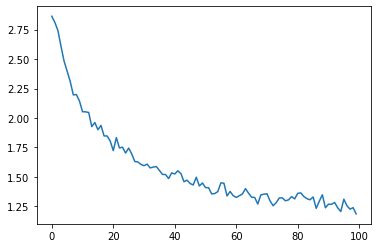

In [84]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

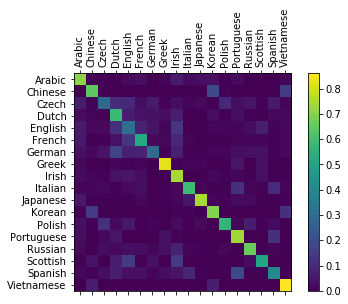

In [85]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [86]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.94) Czech
(-0.99) Russian
(-1.95) English

> Jackson
(-0.77) Scottish
(-0.81) English
(-3.36) Russian

> Satoshi
(-1.03) Italian
(-1.81) Portuguese
(-1.89) Japanese
